# Normal scale mixture tests

In [93]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
#!pip install -e ~/Research/como

In [95]:
from como.component_distributions import NormalScaleMixtureComponent, lossNSM, gradNSM, hessNSM, newtonNSM
from como.component_distributions import _nsm_convolved_logpdf, eta2pi, pi2eta
import numpy as np
import jax.numpy as jnp
from jax import jit
import jax
import matplotlib.pyplot as plt

n = 100000
scales = np.array([1.0, 2.0, 4.0, 8.0, 16.0, 32.0])
eta = np.random.normal(size = scales.size-1)
pi = np.array(eta2pi(eta))

z = np.random.choice(6, replace=True, size=n, p=pi/pi.sum())
beta = np.random.normal(size=n) * scales[z]
se = np.ones(n)
beta_hat = beta + np.random.normal(size=n) * se

In [96]:
import jax.scipy as jsp
from jax import vmap

def mixpdf(beta, se, scales, pi):
    sigmas = jnp.sqrt(se**2 + scales**2)
    return jsp.stats.norm.pdf(beta, loc=0., scale=sigmas) @ pi

mixpdf_vec = vmap(mixpdf, (0, 0, None, None), 0)

L2 = lambda eta: jnp.sum(jnp.log(mixpdf_vec(beta_hat, se, scales, eta2pi(eta))))
L2(eta)

DeviceArray(-380537.16, dtype=float32)

In [97]:
def mix_assignment_prop(beta, se, loc, scales, eta):
    sigmas = jnp.sqrt(se**2 + scales**2)
    # eta0 = jnp.concatenate([eta, jnp.array([0.])])
    logpi = jnp.log(eta2pi(eta))
    loglik = jsp.stats.norm.logpdf(beta, loc, scale=sigmas)
    return jax.nn.softmax(loglik + logpi)

mix_assigment_prop_vec = vmap(
    mix_assignment_prop,
    (0, 0, None, None, None), 0
)

@jit
def emNSM(beta, se, loc, scales, eta):
    R = mix_assigment_prop_vec(beta, se, loc, scales, eta)
    Rsum = R.sum(0)
    pi_new = Rsum / Rsum.sum()
    return pi2eta(pi_new)

In [98]:
np.set_printoptions(precision=2)

L = lambda eta: lossNSM(beta_hat, se, 0., scales, eta)
print(
    f'true loss: {L(eta):.3f}',
    f'true pi: {eta2pi(eta)}'
)

true loss: -380537.188 true pi: [0.11 0.11 0.26 0.22 0.06 0.24]


In [99]:
eta_init = np.zeros(scales.size-1)
print(
    f'init loss: {L(eta_init):.3f}',
    f'init pi: {eta2pi(eta_init)}'
)

init loss: -381315.938 init pi: [0.17 0.17 0.17 0.17 0.17 0.17]


In [100]:
from como.component_distributions import emNSM

eta_est = eta_init
losses = [L(eta_est)]
for _ in range(100):
    eta_est = emNSM(beta_hat, se, 0., scales, eta_est)
    losses.append(L(eta_est))
    print(
        f'loss: {losses[-1]:.3f}',
        f'pi: {eta2pi(eta_est)}'
    )

loss: -381033.625 pi: [0.15 0.16 0.17 0.17 0.17 0.18]
loss: -380936.750 pi: [0.14 0.15 0.17 0.18 0.17 0.19]
loss: -380878.969 pi: [0.13 0.15 0.18 0.18 0.16 0.19]
loss: -380834.500 pi: [0.13 0.15 0.18 0.18 0.16 0.19]
loss: -380797.625 pi: [0.13 0.15 0.19 0.18 0.15 0.2 ]
loss: -380766.312 pi: [0.12 0.15 0.19 0.19 0.15 0.2 ]
loss: -380739.562 pi: [0.12 0.15 0.2  0.19 0.15 0.2 ]
loss: -380716.438 pi: [0.12 0.15 0.2  0.19 0.14 0.2 ]
loss: -380696.500 pi: [0.12 0.15 0.21 0.19 0.14 0.2 ]
loss: -380679.156 pi: [0.11 0.15 0.21 0.19 0.14 0.2 ]
loss: -380664.000 pi: [0.11 0.15 0.21 0.19 0.13 0.2 ]
loss: -380650.812 pi: [0.11 0.15 0.22 0.19 0.13 0.2 ]
loss: -380639.250 pi: [0.11 0.15 0.22 0.19 0.13 0.21]
loss: -380629.094 pi: [0.11 0.15 0.22 0.19 0.12 0.21]
loss: -380620.156 pi: [0.11 0.15 0.22 0.19 0.12 0.21]
loss: -380612.281 pi: [0.11 0.15 0.23 0.19 0.12 0.21]
loss: -380605.344 pi: [0.11 0.15 0.23 0.19 0.12 0.21]
loss: -380599.188 pi: [0.11 0.15 0.23 0.19 0.12 0.21]
loss: -380593.719 pi: [0.1  

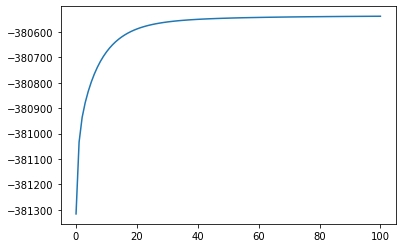

In [101]:
plt.plot(losses)

In [102]:
from como.component_distributions import NormalScaleMixtureComponent

f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)

losses = [f.convolved_logpdf(beta_hat, se).sum()]

In [103]:
for _ in range(20):
    f.update(dict(beta=beta_hat, se=se, y=0))
    losses.append(f.convolved_logpdf(beta_hat, se).sum())

In [104]:
data = dict(beta=beta_hat, se=se, y=1.)

In [105]:
%%time
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
f.update(data, niter=2)
f.convolved_logpdf(beta_hat, se).sum()

CPU times: user 251 ms, sys: 16.5 ms, total: 268 ms
Wall time: 257 ms


DeviceArray(-380936.75, dtype=float32)

In [106]:
f.get_weights(data)
f.index is None

True

In [107]:
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
%timeit f.update(data, niter=20)
f.convolved_logpdf(beta_hat, se).sum()

268 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


DeviceArray(-380537., dtype=float32)

In [108]:
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
%timeit f.update(data, niter=200)
f.convolved_logpdf(beta_hat, se).sum()

664 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


DeviceArray(-380536.25, dtype=float32)

In [109]:
%%time
f = NormalScaleMixtureComponent(
    0.0, scales, np.ones(scales.size) / scales.size)
f.update(data, niter=2000)
f.convolved_logpdf(beta_hat, se).sum()

CPU times: user 5.57 s, sys: 140 ms, total: 5.71 s
Wall time: 4.84 s


DeviceArray(-380536.22, dtype=float32)

## PointNormalMixture

No covariates, just a mixture of a point normal and a scale normal mixture (ie ASH)

In [110]:
## simulate some data
np.random.seed(3)


n = 10000
scales = np.array([1.0, 2.0, 4.0, 8.0, 16.0, 32.0])
eta = np.random.normal(size = scales.size-1)
pi = np.array(eta2pi(eta))
pi0 = 0.5

z = np.random.choice(6, replace=True, size=n, p=pi/pi.sum())
null = np.random.binomial(1, 1 - pi0, size=n)
beta = np.random.normal(size=n) * scales[z] * null
se = np.ones(n)
beta_hat = beta + np.random.normal(size=n) * se

data = dict(
    beta = beta_hat,
    se = se
)

In [111]:
from como.twococomo import PointNormalMixture
from como.utils import is_monotone

fit = PointNormalMixture(
    data,
    f1_args = dict(scales=scales, pi = np.ones(scales.size) / scales.size)
)
fit.fit(niter=10)

(DeviceArray(False, dtype=bool), True)

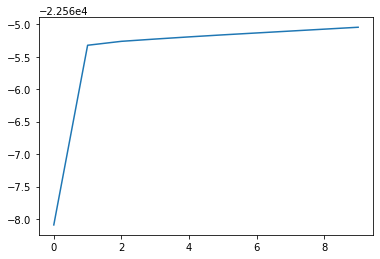

In [112]:
plt.plot(np.array(fit.elbo_history))
fit.converged(), is_monotone(fit.elbo_history)

(-3.0, 3.0)

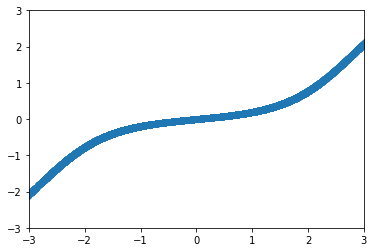

In [113]:
plt.scatter(fit.data['beta'], fit.post_mean)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

## PointNormalMixtureSuSiE

In [114]:
## simulate some data
np.random.seed(3)

n = 10000
p = 50

# normal mixture params
scales = np.array([1.0, 2.0, 4.0, 8.0, 16.0, 32.0])
eta = np.random.normal(size = scales.size-1)
pi = np.array(eta2pi(eta))

# covariates and two-component mixture params
X = np.random.normal(size=n*p).reshape(n, -1)
Z = np.ones(n)[:, None]

coef = np.concatenate([np.ones(3), np.zeros(p-3)])
b0 = np.array([-1])

logits = X @ coef + Z @ b0
pi1 = 1 / (1 + np.exp(-logits))

z = np.random.choice(6, replace=True, size=n, p=pi/pi.sum())
null = np.random.binomial(1, pi1)
beta = np.random.normal(size=n) * scales[z] * null
se = np.ones(n)
beta_hat = beta + np.random.normal(size=n) * se

data = dict(
    beta = beta_hat,
    se = se,
    X = X,
    Z = Z
)

In [115]:
from como.twococomo import PointNormalMixtureSuSiE
from como.utils import is_monotone

fit = PointNormalMixtureSuSiE(
    data,
    f1_args = dict(scales=scales, pi = np.ones(scales.size) / scales.size)
)

fit.fit(niter=50)

(DeviceArray(False, dtype=bool), True)

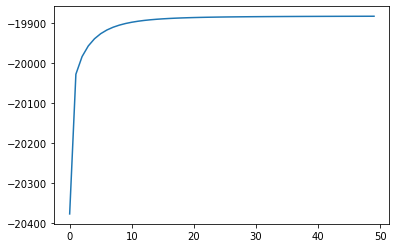

In [116]:
plt.plot(np.array(fit.elbo_history))
fit.converged(), is_monotone(fit.elbo_history)

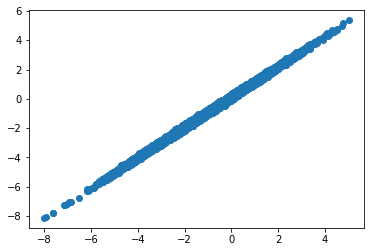

In [117]:
plt.scatter(fit.prior_log_odds, logits)

In [118]:
fit.prior_log_odds

array([-2.11, -3.13, -2.21, ..., -2.83, -0.44,  1.19], dtype=float32)

(-6.0, 6.0)

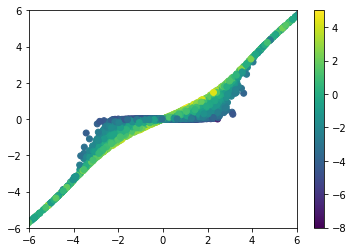

In [119]:
lim = 6
sc = plt.scatter(fit.data['beta'], fit.post_mean, c=fit.prior_log_odds)
plt.colorbar(sc)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

In [120]:
import jax

def pi_scanner(gamma, pi_tilde):
    """
    produce the next pi from the current
    cumulative probability and conditional probability
    use this function to scan over conditional probabilities pi_tilde
    """
    pi = pi_tilde * (1. - gamma)
    gamma = gamma + pi
    return gamma, pi

def pi_tilde2pi(pi_tilde):
    """
    convert vector of conditional mixture probabilities
    to mixture probabilities pi

    pi_tilde[k] = P(draw k given we did not draw 1... k-1)
    pi[k] = P(draw k)
    """
    pi_tilde = jnp.concatenate([pi_tilde, jnp.array([1.0])])
    _, pi = jax.lax.scan(pi_scanner, init=0., xs = pi_tilde)
    return pi

# vectorized version of pi_tilde2pi
pi_tilde2pi_vec = jax.vmap(pi_tilde2pi, 1, 0)

pi_tilde = np.array([
    [0.1, 0.1, 0.1, 0.1],
    [0.2, 0.2, 0.2, 0.2]
]).T

pi = pi_tilde2pi_vec(pi_tilde)

In [121]:
pi.sum(1)

DeviceArray([1., 1.], dtype=float32)

In [122]:
pi_tilde = jnp.array([
    [0.1, 0.1, 0.1, 0.1],
    [0.2, 0.2, 0.2, 0.2]
]).T
pi_tilde.shape

(4, 2)

In [123]:
jnp.concatenate([pi_tilde[0], jnp.array([1.0])])

DeviceArray([0.1, 0.2, 1. ], dtype=float32)

In [124]:
jnp.ndarray

jax._src.numpy.ndarray.ndarray